# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 4
See guidelines on Canvas for details.

This notebook is structured as follows:

1. Section 1 has the basic setup for the notebok, e.g. libraries used in several cells
1. Section 2 has functions to load and prepare the dataset
1. Section 3 rebuilds the network selected in the _experiments_ notebook, to have a clean baseline
1. Section 4 attempts another approach at transfer learning to improve the results from section 1

## 1. Basic setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

To protect against running on FAU's HPC (as of April 2019). We need at least Keras 2.2, where VGG networks support the native CIFAR-10 shape of (32, 32).

In [2]:
import keras

if keras.__version__.startswith('2.1'):
    print('ERROR: This notebook requires at least Keras 2.2')

Using TensorFlow backend.


## 2. Load and prepare the dataset

In [3]:
from keras.datasets import cifar10
from keras.utils import to_categorical

def load_dataset():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    print('x_train shape:', x_train.shape)
    print('Loaded {} train and {} test samples'.format(x_train.shape[0], x_test.shape[0]))

    # Keras' CIFAR-10 is stored as integer
    # Later pieces of code need the data in float type
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Since we are using a neural network, we need to convert the categories from labels
    # (numbers) to a hot-encoded vector
    # See https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
    # on why we need to hot-encode in this case
    num_classes = len(np.unique(y_train))
    print('Hot-enconding {} classes'.format(num_classes))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    # Most examples using CIFAR-10 have the lines of code below as part of loading and
    # preparing the dataset. Since we are using a pretrained network, we will use the
    # network's `preprocess_input()` instead. It will take care of it and anything
    # else that was done to the image at training time for that network.
    # x_train /= 255
    # x_test /= 255
          
    return x_train, y_train, x_test, y_test

## 3. Network from the _experiments_ notebook (bottleneck transfer learning)

In the _experiments_ notebook we used [bottleneck transfer learning](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html). 

In this transfer learning method, we extract features from the convolution layers and use them to train another network (usually composed of dense layers).

This section reproduces the bottleneck transfer from the _experiments_ notebook to create a baseline.

### 3.1 Load the base network, without the dense layers

The base network is Keras' pretrained VGG16.

Contrary to what we did in the _experiments_ notebook, we specify an `input_shape` that matches the CIFAR-10 images. This is needed for the section where we train the base model together with a new top layer. To "glue" them together we need exact dimensions for the last layer of the base model (to serve as `input_shape` for the new top layer).

In [4]:
from keras.applications import vgg16

conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

### 3.2 Load and prepare the dataset

In [5]:
x_train, y_train, x_test, y_test = load_dataset()

x_train shape: (50000, 32, 32, 3)
Loaded 50000 train and 10000 test samples
Hot-enconding 10 classes


### 3.3 Extract features

Extract the features from the training set.

Since this is the most time consuming step of the bottleneck transfer learning process, we will save the results to a file and attempt to restore from that file before calculating the predictions agian. 

**IMPORTANT:** if anything changes in the prediction process (e.g. a different base network configuration), remember to delete the files to force new predictions to be calculated.

In [6]:
from skimage import transform

""" Preprocess and store results of `predict()` for an array of images.""" 
def predict_all_images(images, model, base_module, new_size=None):
    print('Predicting {} images'.format(len(images)))

    predictions = []
    for i, img in enumerate(images):
        # Simple progress indicator
        if i % 500 == 0:
            print('{}'.format(i), end=", ")
            
        # Resize, if asked to do so
        if new_size is not None:
            img = transform.resize(img, new_size, order=1, mode='reflect')
            
        # Expand dimensions to match the format Keras needs in `predict()`
        # In gist: add one more dimension to hold the batch size (1 image in this case)
        x = np.expand_dims(img, axis=0)
        
        # Normalize pixel values to what the model was trained one
        # It varies by model - see https://stackoverflow.com/a/47556342
        x = base_module.preprocess_input(x)

        predictions.append(model.predict(x))

    return predictions

In [7]:
import os
import pickle

""" Load cached predictions, if avaiable. If not, predict and cache them."""
def calculate_predictions(dataset, model, file_name):
    if os.path.isfile(file_name):
        print('Loading predictions from {}'.format(file_name))
        with open (file_name, 'rb') as fp:
            features = pickle.load(fp)
    else:
        features = predict_all_images(dataset, model, vgg16, new_size=None)
        with open(file_name, 'wb') as fp:
            pickle.dump(features, fp)
            
    # At this point we may have a list (from predict_all_images)
    # Change to a NumPy array - what the network expects
    features = np.asarray(features)
    
    # We also have one extra layer in the array, (<samples>, 1, 1, 1, x), while
    # the networks expect four dimensions,  (<samples>, 1, 1, x)
    features = np.squeeze(features, axis=1)

    return features

In [8]:
%%time
TRAIN_FEATURES_FILE = 'predicted_train_features_final_notebook'
x_train_features = calculate_predictions(x_train, conv_base, TRAIN_FEATURES_FILE)

Predicting 50000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, CPU times: user 45min 19s, sys: 3min 27s, total: 48min 46s
Wall time: 9min 55s


Extract features from the test set.

In [9]:
%%time
TEST_FEATURES_FILE = 'predicted_test_features_final_notebook'
x_test_features = calculate_predictions(x_test, conv_base, TEST_FEATURES_FILE)

Predicting 10000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, CPU times: user 9min 13s, sys: 43.3 s, total: 9min 56s
Wall time: 2min 3s


### 3.5 Train the final classifier on the extracted features

Create the classifier.

A few observations from experiments:

- Batch normalization resulted in better accuracy than dropout
- Learning rate can be reasonably high, thanks to batch normalization, resulting in convergence after a few epochs
- Small dense layers performed nearly as well as large dense layers (> 1024) and are faster to train

In [10]:
from keras import models
from keras import layers
from keras import optimizers 
from keras import losses

model = models.Sequential()
# Since we extracted predictions from a convolution layer, the first step is to
# flatten the results, just we like we do when we train the complete network.
# TODO: make more generic with x_train_features.shape[1:]
model.add(layers.Flatten(input_shape=(1, 1, 512,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

Train the classifier, using early stopping to get a good accuracy without much guessing.

In [11]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1)

history = model.fit(x_train_features, y_train,
                    epochs=100, 
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 3s 71us/step - loss: 1.1770 - acc: 0.5940 - val_loss: 0.9947 - val_acc: 0.6698
Epoch 2/100
45000/45000 [==============================] - 3s 57us/step - loss: 0.9979 - acc: 0.6501 - val_loss: 0.9668 - val_acc: 0.6724
Epoch 3/100
45000/45000 [==============================] - 3s 61us/step - loss: 0.9491 - acc: 0.6666 - val_loss: 0.9483 - val_acc: 0.6868
Epoch 4/100
45000/45000 [==============================] - 3s 65us/step - loss: 0.9181 - acc: 0.6793 - val_loss: 0.9449 - val_acc: 0.6888
Epoch 5/100
45000/45000 [==============================] - 3s 67us/step - loss: 0.8866 - acc: 0.6910 - val_loss: 0.9513 - val_acc: 0.6820
Epoch 6/100
45000/45000 [==============================] - 3s 59us/step - loss: 0.8721 - acc: 0.6944 - val_loss: 0.9473 - val_acc: 0.6866
Epoch 00006: early stopping


### 3.6 Evaluate the final classifier

Check the training history.

In [12]:
# Adapted from https://keras.io/visualization/ - changed to side-by-side plots to save space
from matplotlib.ticker import MaxNLocator

def plot_keras_history(history):

    # Side-by-side plots, wider than taller, to make run for the epochs
    f = plt.figure(figsize=(12,4))
    ax_acc = f.add_subplot(121)
    ax_loss = f.add_subplot(122)

    # Plot training & validation accuracy values
    ax_acc.plot(history.history['acc'])
    ax_acc.plot(history.history['val_acc'])
    ax_acc.set_title('Model accuracy')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.legend(['Train', 'Test'], loc='upper left')
    ax_acc.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot training & validation loss values
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_title('Model loss')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.legend(['Train', 'Test'], loc='upper left')
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

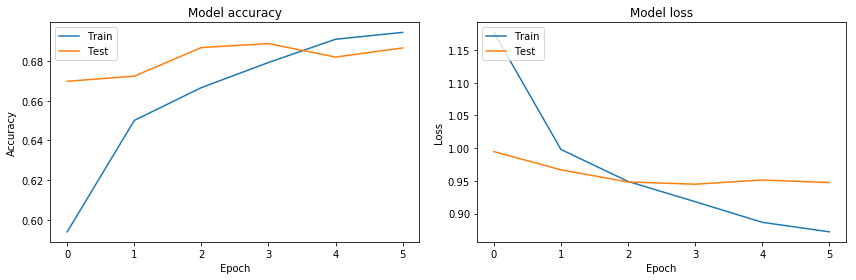

In [13]:
plot_keras_history(history)

Check accuracy on the test dataset.

In [14]:
scores = model.evaluate(x_test_features, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 0s 19us/step
Test loss: 0.9718010419845581
Test accuracy: 0.6737


## 4. Transfer learning with retraining

In this section we will load the same pretrained network used in the previous section and train some of its top layers on our dataset.

Even though these top layers are supposed to be generic feature extractors, they were trained on a different set of images. 

The goal of retraining the top layers is for them to learn features from our dataset.

Note: we could have proceeded from the previous section, where we already have a base network and a pretrained dense layer (two pieces we need for this section). However, in this section we will rebuild those steps to 1) have a complete solution in one place and 2) make sure we are not carrying over information from that section that could inadvertently help in this section (e.g. train again a network that has already been trained).

### 4.1 Load and prepare the base network

We will retrain the last series of convolution layers (and their associated pooling layer) in the VGG network.

In this step we load the base network and freeze all layers we will not train.

In [15]:
from keras.applications import vgg16

conv_base2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze all layers we don't want to train
for layer in conv_base2.layers[:-4]:
    layer.trainable = False

# Check if we got what we wanted
for layer in conv_base2.layers:
    print('{}\t{}\t{}\t'.format(layer.name, layer.output_shape, layer.trainable))

input_2	(None, 32, 32, 3)	False	
block1_conv1	(None, 32, 32, 64)	False	
block1_conv2	(None, 32, 32, 64)	False	
block1_pool	(None, 16, 16, 64)	False	
block2_conv1	(None, 16, 16, 128)	False	
block2_conv2	(None, 16, 16, 128)	False	
block2_pool	(None, 8, 8, 128)	False	
block3_conv1	(None, 8, 8, 256)	False	
block3_conv2	(None, 8, 8, 256)	False	
block3_conv3	(None, 8, 8, 256)	False	
block3_pool	(None, 4, 4, 256)	False	
block4_conv1	(None, 4, 4, 512)	False	
block4_conv2	(None, 4, 4, 512)	False	
block4_conv3	(None, 4, 4, 512)	False	
block4_pool	(None, 2, 2, 512)	False	
block5_conv1	(None, 2, 2, 512)	True	
block5_conv2	(None, 2, 2, 512)	True	
block5_conv3	(None, 2, 2, 512)	True	
block5_pool	(None, 1, 1, 512)	True	


### 4.2 Create and prepare the top layers

The top layer of the network will do the final class predictions. To do that, it will be trained on our dataset, together with the layers from the base network we unfroze in the previous step.

However, before training the top layer and the base network together, we first need to train the top layer by itself. The reason for that is explained in [this Keras blog post on transfer learning](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html):

> in order to perform fine-tuning, all layers should start with properly trained weights: for
> instance you should not slap a randomly initialized fully-connected network on top of a
> pre-trained convolutional base. This is because the large gradient updates triggered by the
> randomly initialized weights would wreck the learned weights in the convolutional base. In 
> our case this is why we first train the top-level classifier, and only then start fine-tuning
> convolutional weights alongside it.

In this step we will create weights for the top layer that are compatible with the convolution layer of the base network.

Because we use the top layer in a few places, this function ensures that we always create the top layer with the same architecture in all places.

**IMPORTANT:** If you change this function, run all steps that depend on it again, including the weight generation step.

In [16]:
def get_top_layer(input_shape):
    top_layer = models.Sequential()
    top_layer.add(layers.Flatten(input_shape=input_shape))
    top_layer.add(layers.Dense(128, activation='relu'))
    top_layer.add(layers.BatchNormalization())
    top_layer.add(layers.Dense(10, activation='softmax'))

    return top_layer

The starting point is the features extracted in the previous section. They were generated by the base layer and are therefore adjusted to the weights those layers uses.

The extracted features are now the training data for this layer.

In [17]:
x_train, y_train, x_test, y_test = load_dataset()

x_train shape: (50000, 32, 32, 3)
Loaded 50000 train and 10000 test samples
Hot-enconding 10 classes


In [18]:
# IMPORTANT: since the base model we use in this section is exactly the same as the one
# used in the previous section, we can use the same cached files. If the models become
# different in the future, we need new file names in this section.

x_train_features = calculate_predictions(x_train, conv_base2, TRAIN_FEATURES_FILE)
x_test_features = calculate_predictions(x_test, conv_base2, TEST_FEATURES_FILE)

Loading predictions from predicted_train_features_final_notebook
Loading predictions from predicted_test_features_final_notebook


We will train the layer and save the weights. These weights are the "properly trained weights" that we need.

This step will take only a few seconds because we are training a very small network.

In [19]:
from keras import optimizers
from keras import losses

top_layer_weights = get_top_layer(x_train_features.shape[1:])

top_layer_weights.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

In [20]:
from keras import callbacks

# We will train with early stopping to get good results, but also not waste
# time with too much training (and risk overfitting as well)
early_stopping = callbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1)

top_layer_weights.fit(x_train_features, y_train,
                      epochs=50,
                      batch_size=20,
                      validation_split=0.1,
                      callbacks=[early_stopping])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 4s 86us/step - loss: 1.1473 - acc: 0.6053 - val_loss: 0.9806 - val_acc: 0.6636
Epoch 2/50
45000/45000 [==============================] - 4s 81us/step - loss: 0.9910 - acc: 0.6602 - val_loss: 0.9525 - val_acc: 0.6646
Epoch 3/50
45000/45000 [==============================] - 4s 80us/step - loss: 0.9426 - acc: 0.6759 - val_loss: 0.9299 - val_acc: 0.6766
Epoch 4/50
45000/45000 [==============================] - 4s 80us/step - loss: 0.9096 - acc: 0.6872 - val_loss: 0.9175 - val_acc: 0.6918
Epoch 5/50
45000/45000 [==============================] - 4s 80us/step - loss: 0.8789 - acc: 0.6958 - val_loss: 0.9209 - val_acc: 0.6848
Epoch 6/50
45000/45000 [==============================] - 4s 82us/step - loss: 0.8513 - acc: 0.7097 - val_loss: 0.9203 - val_acc: 0.6860
Epoch 00006: early stopping


Check accuracy on the test set.

In [21]:
scores = top_layer_weights.evaluate(x_test_features, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 0s 16us/step
Test loss: 0.9462532428741455
Test accuracy: 0.6826


In [22]:
WEIGHTS_FILE = 'bottleneck_layer_weights.h5'

top_layer_weights.save_weights('bottleneck_layer_weights.h5')

In [23]:
# We no longer need this model - free up some memory
del top_layer_weights

### 4.3 Train with the base network

In the previous section we already achieved over 90% accuracy.

In this section we will train the base network together with the new top layers to improve that.

**NOTE:** when running the notebook from top to bottom, we could simply use the top layer we just trained in the above section. We are doing it in separate steps (train, save to file, load from file) to illustrate the full workflow and to be able to run only this section of the notebook later.

In [24]:
top_layer = get_top_layer(conv_base2.output_shape[1:])
top_layer.load_weights(WEIGHTS_FILE)

In [25]:
combined_model = models.Sequential()
combined_model.add(conv_base2)
combined_model.add(top_layer)

Show the model we built.

What we are looking for here: a large number of non-trainable parameters. If that numbers is small, we didn't freeze the layers correctly.

In [26]:
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential_3 (Sequential)    (None, 10)                67466     
Total params: 14,782,154
Trainable params: 7,146,634
Non-trainable params: 7,635,520
_________________________________________________________________


Compile the model.

Note that we are using a large learning rate. We can afford that because we are using batch normalization.

In [27]:
combined_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                  loss=losses.categorical_crossentropy,
                  metrics=['accuracy'])

Train the model.

In [28]:
combined_model.fit(x_train, y_train,
                   epochs=50,
                   batch_size=20,
                   validation_split=0.1,
                   callbacks=[early_stopping])

Train on 45000 samples, validate on 5000 samples
Epoch 1/50
45000/45000 [==============================] - 805s 18ms/step - loss: 1.1864 - acc: 0.5726 - val_loss: 1.8449 - val_acc: 0.4940
Epoch 2/50
45000/45000 [==============================] - 804s 18ms/step - loss: 0.9409 - acc: 0.6720 - val_loss: 1.1389 - val_acc: 0.6074
Epoch 3/50
45000/45000 [==============================] - 824s 18ms/step - loss: 0.8637 - acc: 0.7030 - val_loss: 1.0129 - val_acc: 0.6500
Epoch 4/50
45000/45000 [==============================] - 768s 17ms/step - loss: 0.8070 - acc: 0.7237 - val_loss: 0.9557 - val_acc: 0.6920
Epoch 5/50
45000/45000 [==============================] - 865s 19ms/step - loss: 0.7621 - acc: 0.7401 - val_loss: 0.9144 - val_acc: 0.6996
Epoch 6/50
45000/45000 [==============================] - 845s 19ms/step - loss: 0.7221 - acc: 0.7520 - val_loss: 0.8891 - val_acc: 0.6948
Epoch 7/50
45000/45000 [==============================] - 836s 19ms/step - loss: 0.6864 - acc: 0.7655 - val_loss: 0.8

### 4.4 Evaluate the results

Check accuracy on the test data.

In [29]:
scores = combined_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 52s 5ms/step
Test loss: 0.9208349465370178
Test accuracy: 0.7047


Calculate and visualize the confusion matrix.

(Reminder: rows = actual class, columns = predicted class)

In [31]:
predictions = combined_model.predict(x_test, verbose=1)

10000/10000 [==============================] - 48s 5ms/step


In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)

[[838  65  22   3  29   1   4  20   6  12]
 [  2 956   2   0   1   1   6   5   1  26]
 [ 48  20 640   3 117  47  81  42   0   2]
 [ 16  31  72 199  85 359 128  71   1  38]
 [ 12  10  34   1 740  21  76 100   2   4]
 [  9  12  32  15  49 682  74 119   0   8]
 [  4  28  28   3  32  20 877   4   0   4]
 [  6  13  12   0  47  30   7 873   0  12]
 [134 229  13   8  19   1   3   5 538  50]
 [ 20 237   2   1   8   3   5  19   1 704]]


In graphical format (lighter colors = higher accuracy).

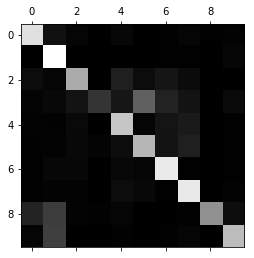

In [40]:
plt.matshow(cm, cmap=plt.cm.gray)
plt.show()

## 5. Analysis and conclusions

Training with an unfrozen convolution layer improves overall accuracy by about 2%.

Although the numbers in the notebook show that the cost for that improvement is a much large training time (from "a few seconds" to "about two hours"), on a GPU the training time would be significantly faster, in the range of "a few minutes". It is still larger, but back to a more manageable range.

Applications that require maximum accuracy should unfreeze a convolution layer. Applications that require the minimum possible training time (perhaps online training, as samples are collected) should freeze all convolution layers and train only the smallest possible dense layer.

### 5.1 Possible next steps to improve the results

The training process is already stopping when overfit begins to happen (using early stopping), so training for longer in this configuration may not yield better results.

With that in mind, a few ideas to improve accuracy:

1. Increase the `patience` value in early stopping to check if the network is going through a plateau at that point.
1. Add data augmentation.
1. Change the architecture of the top layer, e.g. add more hidden layers, add/remove neurons, etc.